In [ ]:
!pip install apache_beam mwparserfromhell
!pip install transformers
!pip install datasets
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# multilingual CLIP pretrained
# https://github.com/FreddeFrallan/Multilingual-CLIP
!pip install multilingual-clip
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp39-cp39-linux_x86_64.whl size=36924 sha256=85a7efdbe3c9fe15271dbf498fb2a1326cbdc21e95

In [ ]:
import os
import sys

repo = 'zeroshot-unsupervised-mt'
# if os.path.isdir(repo):
#   !rm -rf {repo}

!rm -rf {repo}
!git clone https://github.com/pinnouse/zeroshot-unsupervised-mt.git

if not repo in sys.path:
  sys.path.insert(1, repo)

Cloning into 'zeroshot-unsupervised-mt'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 288 (delta 102), reused 127 (delta 80), pack-reused 129
Receiving objects: 100% (288/288), 379.87 KiB | 11.87 MiB/s, done.
Resolving deltas: 100% (177/177), done.


Load Language Data

In [ ]:
from data_loader import data_loader
from google.colab import drive
import pickle
drive.mount('/content/gdrive')

with open('/content/gdrive/My Drive/CSC413/Project/en_reparsed.pickle', 'rb') as f:
  ds_en = pickle.load(f)

# ds_fr = data_loader("fr")
#ds_frr = data_loader("frr")
ds_ar = data_loader("ar")
#ds_jp = data_loader("jp")

Mounted at /content/gdrive


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4207 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/469 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/SaiedAlshahrani___parquet/SaiedAlshahrani--Moroccan_Arabic_Wikipedia_20230101-65e7a7ddf17906d4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Setting up models

In [ ]:
# Insert training code here
import torch
from models import Decoder, Transformer, Translator, Discriminator
from transformers import BertTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

transformer = Transformer(tokenizer.vocab_size, d_hid=512, nlayers=3)
real_decoder = Decoder(tokenizer.vocab_size, nlayers=3)
translate = Translator(hidden=512)
discriminator = Discriminator()

real_decoder.to(device)
transformer.to(device)
translate.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

Load Decoder Checkpoint

In [ ]:
decoder_checkpoint = torch.load('/content/gdrive/My Drive/CSC413/Project/decoder-ckpt/ckpt-Decoder-epoch-49.pt', map_location=torch.device(device))
checkpoint = torch.load('/content/gdrive/My Drive/CSC413/Project/main-ckpts/ckpt-epoch-45.pt', map_location=torch.device(device))

Train the model

Epoch 46:


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


	train loss (decoder)   : 0.0
	train loss (generator) : 0.884883925318718
	train loss (discrim)   : 0.6932843497821263
	train loss (translator): 0.6936878427153542
	took: 78.787761 seconds
Probability Discriminator classifies English Embs:  tensor(0.4994, device='cuda:0')
Probability Discriminator classifies Other Embs as English Embs:  tensor(0.4997, device='cuda:0') 

Epoch 47:
	train loss (decoder)   : 0.0
	train loss (generator) : 0.8396630727109455
	train loss (discrim)   : 0.6932733094408399
	train loss (translator): 0.6938425501187643
	took: 77.973482 seconds
Probability Discriminator classifies English Embs:  tensor(0.4994, device='cuda:0')
Probability Discriminator classifies Other Embs as English Embs:  tensor(0.4996, device='cuda:0') 

Epoch 48:
	train loss (decoder)   : 0.0
	train loss (generator) : 0.8512127811000461
	train loss (discrim)   : 0.6932182688088644
	train loss (translator): 0.6942143865994045
	took: 77.692647 seconds
Probability Discriminator classifies Englis

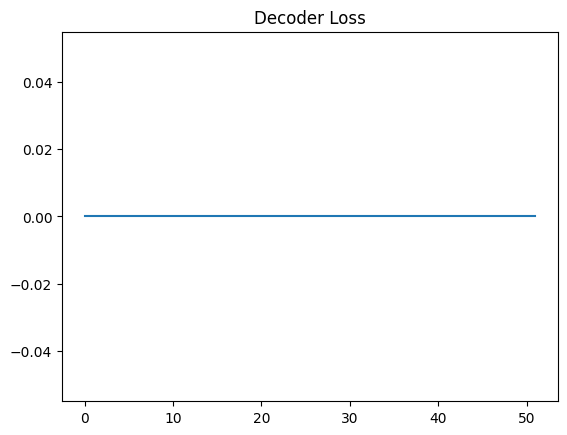

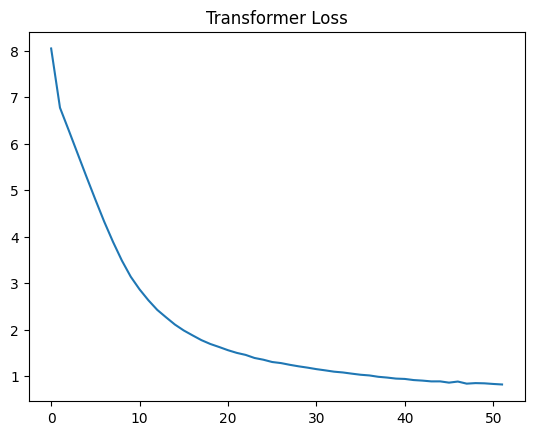

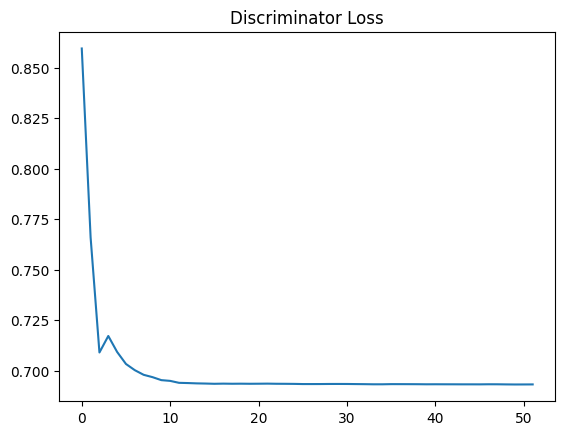

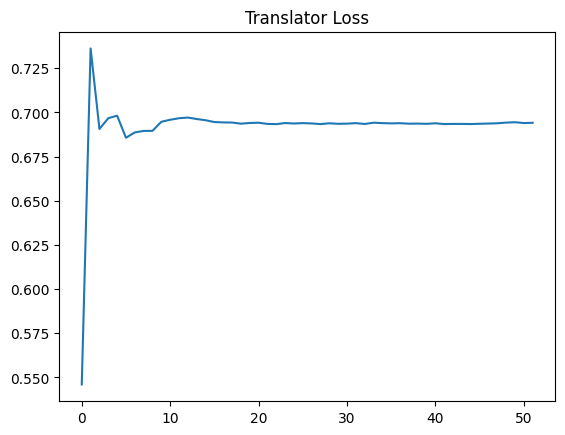

In [ ]:
ckpt_path = '/content/gdrive/My Drive/CSC413/Project'

import importlib
import training
importlib.reload(training)
from training import train

train(real_decoder, transformer, discriminator, translate, tokenizer=tokenizer,
      real_train=ds_en['train'], other_train=ds_ar[0], real_valid=ds_en['validation'], other_valid=ds_ar[1],
      device=device,
      ckpt_path=ckpt_path, batch_size=40, ckpt_interval=5, epochs=51, decoder_checkpoint=decoder_checkpoint,
      checkpoint=checkpoint,
      )